[<img  align="right" src="https://www.gustaveroussy.fr/sites/all/themes/gustave_roussy/logo.png">](https://www.gustaveroussy.fr/)
# ScreenFail prediction 
*Modelisation with Random Forest to predict if a patient will be Screen Fail or not*

### 

In [32]:
# Import necessary librairies
import os

import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, GridSearchCV, train_test_split,RandomizedSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, average_precision_score, \
    classification_report, recall_score, f1_score, roc_auc_score, make_scorer, auc
from sklearn.covariance import EmpiricalCovariance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from gensim.models import Word2Vec, KeyedVectors 

import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, Birch, DBSCAN

from w2v_clusters import WordClustering
from pre_process import process

import shap


*Load and prepares EHRs for further processing*

In [59]:
# Load EHRs
df_all=pd.read_csv(os.path.join("./Data", "df_CRs_inclusion.csv"), encoding='utf-8')
df_all=df_all[df_all['CompleteValues']]

# Separe Test and Train/Validation sets
split = df_all['Cohort']

ehr_raw_train_val=df_all[split!="Test"].value.apply(str)
ehr_raw_test=df_all[split=="Test"].value.apply(str)

y_train_val=df_all.loc[split!="Test"].screenfail
y_test=df_all.loc[split=="Test"].screenfail
pd.value_counts(y_train_val) # give numbers of ScreenFail in test and val cohort


0    920
1    697
Name: screenfail, dtype: int64

In [96]:
print(len(y_train))


1337


*Processing of EHRS*

In [5]:
# Preprocessing using spacy: html,stopwords,ponctuation and lemmatisation
  
ehr_train_val=ehr_raw_train_val.apply(process)    
ehr_test=ehr_raw_test.apply(process)    

# Delete empty health records
ehr_train_val = pd.DataFrame(data=ehr_train_val)
ehr_test = pd.DataFrame(data=ehr_test)

# Found index of null DafaFrames and delete them
index_with_nan_train_val = ehr_train_val.index[ehr_train_val.isnull().any(axis=1)]
index_with_nan_test = ehr_test.index[ehr_test.isnull().any(axis=1)]

ehr_train_val=ehr_train_val.drop(index_with_nan_train_val,0, inplace=False)
ehr_test=ehr_test.drop(index_with_nan_test,0, inplace=False)

ehr_train_val=pd.Series(ehr_train_val.value) 
ehr_test=pd.Series(ehr_test.value)

y_train_val=y_train_val.drop(index_with_nan_train_val,0, inplace=False)
y_test=y_test.drop(index_with_nan_test,0, inplace=False)



In [64]:
print(len())

Int64Index([101, 108, 531, 1006], dtype='int64')


*Separe Training and validation test*

In [6]:
split=split.drop(index_with_nan_train_val,0, inplace=False)
index_val=split.index[split == "Val"].to_list()
index_train=split.index[split == "Train"].to_list()
DF_val=ehr_train_val[index_val]
DF_train=ehr_train_val[index_train]

y_val=y_train_val[index_val]
y_train=y_train_val[index_train]

In [82]:
ehr_train_val

1       [onco, radiothérapie, dr, pechoux, dr, al, mok...
2       [reunion, concertation, pluridisciplinaire, gy...
3       [qcrcpm, moscato, cr, dicter, dr, bahleda, mr,...
4       [patient, voir, dr, fuerea, patient, âgé, an, ...
5       [destinataire, cte, poumon, dr, interne, dicte...
                              ...                        
1877    [cr, dicte, ariane, laparra, cr, tape, charlen...
1878    [cr, dicte, marie, auvray, interne, yolla, el,...
1881    [cr, dicte, ariane, laparra, cr, tape, charlen...
1883    [cr, dicte, ariane, laparra, cr, tape, charlen...
1884    [cr, dicte, capucine, baldini, cr, tape, lydie...
Name: value, Length: 1594, dtype: object

*Initialisation of cross validation*

In [8]:
# CV is then performed with StratifiedShuffleSplit funtion
cv = StratifiedShuffleSplit(n_splits=5, test_size=len(DF_val)/(len(DF_val)+len(DF_train)), random_state=42)
scoring = {'AUC': 'roc_auc','f1':'f1', 'Recall': 'recall'}

*Search of best numbers of clusters for transformation into cluster vectors*

In [ ]:
auc_curve=[]
f1_score_curve=[]
recall_curve=[]
nbe = [10,25,50,75,100,200,300,400,500,750,1000]

for n in nbe:
    
    w2v_cluster = WordClustering( pretrained=True,
                                  model_path="w2v_model.kv",
                                  n_clusters=n,
                                 clustering=AgglomerativeClustering())


    model_vectors =w2v_cluster.fit(ehr_train_val)

    ehrs_vec_val=model_vectors.transform(DF_val) 
    ehrs_vec_train_val=model_vectors.transform(ehr_train_val) 
    
    ## Random Forest and search for best parameters

    rf = RandomForestClassifier(random_state=15)

    params = {'n_estimators': np.arange(5, 200, 1),
              'max_features': ['log2', 'sqrt'],
              'min_samples_leaf': np.arange(1E-8, 0.01, 1E-8)}

    grid = RandomizedSearchCV(rf,
                        param_distributions=params,
                        cv=cv,
                        scoring=scoring,
                        refit='Recall',
                        return_train_score=False,
                        verbose=1,
                        n_jobs=-1,
                        random_state=42,
                        n_iter=1200)

    grid.fit(ehrs_vec_train_val, y_train_val)

    y_pred_val = grid.predict(ehrs_vec_val)
    y_probs_val = grid.predict_proba(ehrs_vec_val)

    fpr, tpr, threshold = roc_curve(y_val,y_probs_val[:,1])
    auc_curve.append(auc(fpr,tpr))    
    f1_score_curve.append(f1_score(y_val, y_pred_val))
    recall_curve.append(recall_score(y_val, y_pred_val))



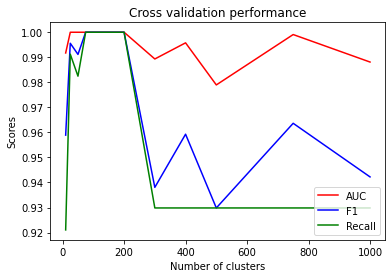

<Figure size 432x288 with 0 Axes>

In [94]:
# Curve of scores VS number of clusters on validation cohort

plt.title('Cross validation performance')
plt.plot(nbe, auc_curve,'r',label='AUC')
plt.plot(nbe, f1_score_curve,'b',label='F1')
plt.plot(nbe, recall_curve,'g',label='Recall')
plt.legend(loc = 'lower right')
plt.ylabel('Scores')
plt.xlabel('Number of clusters')
plt.show()
plt.savefig("./Plots/crossValidationPerformances.pdf")

*Transformation into cluster vectors*

In [85]:
w2v_cluster = WordClustering( pretrained=True,
                              model_path="w2v_model.kv",
                              n_clusters=200,
                             clustering=AgglomerativeClustering())


model_vectors =w2v_cluster.fit(ehr_train_val)

ehrs_vec_train_val=model_vectors.transform(ehr_train_val)
#x_w2v2_val=x_w2v.transform(DF_val) ?
#x_w2v2_train=x_w2v.transform(DF_train) ?
ehrs_vec_test=model_vectors.transform(ehr_test)

oui


*Random Forest and search for best parameters*

In [86]:

rf = RandomForestClassifier(random_state=15)

params = {'n_estimators': np.arange(5, 200, 1),
          'max_features': ['log2', 'sqrt'],
          'min_samples_leaf': np.arange(1E-8, 0.01, 1E-8)}

grid = RandomizedSearchCV(rf,
                    param_distributions=params,
                    cv=cv,
                    scoring=scoring,
                    refit='Recall',
                    return_train_score=False,
                    verbose=1,
                    n_jobs=-1,
                    random_state=42,
                    n_iter=1200)

grid.fit(ehrs_vec_train_val, y_train_val)

y_pred_train_val = grid.predict(ehrs_vec_train_val)


Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:  8.8min finished


Results

In [97]:
best_params=grid.best_params_ # store best parameters of the random forest

print("Les meilleurs paramètres sont :", best_params)
y_pred_train_val = grid.predict(ehrs_vec_train_val)
y_prob_train_val = grid.predict_proba(ehrs_vec_train_val) # get probabilities of each class

y_pred_test = grid.predict(ehrs_vec_test)
y_prob_test = grid.predict_proba(ehrs_vec_test)

                                                           
### Results for test set ###

print("Results for test set ","\n\n")

mat_test=confusion_matrix(y_test, y_pred_test)
print("confusion matrix:" , mat_test,"\n")

fpr_test, tpr_test, threshold_test = roc_curve(y_test,y_prob_test[:,1])
score_auc_test = auc(fpr_test,tpr_test)
print("score auc: ",score_auc_test,"\n")

score_f1_test=f1_score(y_test, y_pred_test)
print("score f1: ",score_f1_test,"\n")

score_recall_test=recall_score(y_test, y_pred_test)
print("score recall: ",score_recall_test ,"\n")

### Results for train and validation set ###

print("Results for training and validation set ","\n\n")
                                               
mat_train_val=confusion_matrix(y_train_val, y_pred_train_val)
print("confusion matrix:",mat_train_val,"\n")
                                               
fpr_train_val, tpr_train_val, threshold_train_val = roc_curve(y_train_val,y_prob_train_val[:,1])
score_auc_train_val=auc(fpr_train_val,tpr_train_val)
print("score auc: ",score_auc_train_val,"\n")

score_f1_train_val=f1_score(y_train_val, y_pred_train_val)
print("score f1: ",score_f1_train_val,"\n")

score_recall_train_val=recall_score(y_train_val, y_pred_train_val)
print("score recall: ",score_recall_train_val,"\n")

Les meilleurs paramètres sont : {'n_estimators': 187, 'min_samples_leaf': 0.0007037, 'max_features': 'sqrt'}
Results for test set  


confusion matrix: [[136  23]
 [ 20  85]] 

score auc:  0.8804731955675352 

score f1:  0.7981220657276996 

score recall:  0.8095238095238095 

Results for training and validation set  


confusion matrix: [[901   0]
 [  4 689]] 

score auc:  0.999770176795704 

score f1:  0.9971056439942113 

score recall:  0.9942279942279942 



In [100]:
len(y_train_val)

1594

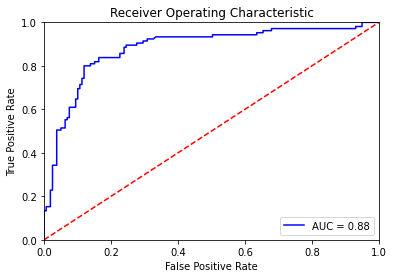

In [89]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC = %0.2f' % score_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("./Plots/roc_curve.pdf")
plt.show()

Interpretation

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


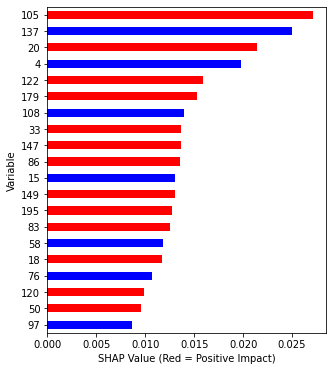

In [91]:

best_rf=grid.best_estimator_

# Shap values

DF_ehr_train_val=pd.DataFrame(ehrs_vec_train_val)
DF_ehr_train_val.columns=range(200)

shap_values = shap.TreeExplainer(best_rf).shap_values(DF_ehr_train_val)

shap_values=np.array(shap_values)[0]
explainer=shap.TreeExplainer(best_rf)

# The following code comes from :  https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
###

shap_v = pd.DataFrame(shap_values)
feature_list = DF_ehr_train_val.columns
shap_v.columns = feature_list
df_v = DF_ehr_train_val.copy().reset_index().drop('index',axis=1)

# Determine the correlation in order to plot with different colors
corr_list = list()
for i in feature_list:
    b = np.corrcoef(shap_v[i],df_v[i])[1][0]
    corr_list.append(b)
corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
# Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
corr_df.columns  = ['Variable','Corr']
corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')

# Plot it
shap_abs = np.abs(shap_v)
k=pd.DataFrame(shap_abs.mean()).reset_index()
k.columns = ['Variable','SHAP_abs']
k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
k2 = k2.sort_values(by='SHAP_abs',ascending = True)
colorlist = k2['Sign']
ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
ax.set_xlabel("SHAP Value (Red = Negative Impact)")
plt.savefig("./Plots/SHAP_values.pdf") 
###

In [104]:
# Print words of most important cluster

words_by_cluster=model_vectors.get_clusters_words()
print(words_by_cluster['20'])

['sang', 'bandelette', 'bu', 'pnp', 'protéine', 'perfusion', 'strictement', 'perturber', 'trace', 'nitrite', 'hématologique', 'composant', 'monoclonal', 'anémie', 'thrombopénie', 'pancytopénie', 'microbiologique', 'coprocultures', 'electrophorèse', 'neutropénie', 'normo', 'béta', 'grippe', 'vrs', 'hémoculture', 'ecbu', 'culture', 'immunofixation', 'leucopénie', 'cdc', 'lymphopénie', 'protéines', 'pct', 'germe', 'électrophorèse', 'bactériologique', 'coproculture', 'normalisation', 'antériorité', 'immunoglobuline', 'clostridium', 'bactérien', 'thrombopéni', 'parasite', 'thrombocytopénie', 'hépatalgie', 'osmolarité', 'parasitologiqu', 'exception', 'réactivation', 'postchimiothérapi', 'épigastralgie', 'ira', 'vgm', 'rectosigmoïdoscopie', 'antibiogramme', 'amylasémie', 'postprandial', 'toxine', 'parasitologique', 'revenues', 'régénérative', 'croix', 'flore', 'régénératif', 'aplasie', 'fufol', 'protéïne', 'protéïnurie', 'leucocyturie', 'pneumoniti', 'glycosurie', 'procalcitonin', 'microbien'

*T-test*

In [111]:
# DataFrame regroupant true (SF or not SF), predicted (SF or not SF)

ehr_train_val.index=range(len(ehr_train_val))
DF_pred_true=ehr_train_val.copy()
DF_pred_true=pd.DataFrame(DF_pred_true)
DF_pred_true.columns=['CR']
y_train_val.index=range(len(y_train_val))
DF_pred_true['true SF']=y_train_val
DF_pred_true['predicted_SF']=pd.Series(y_pred_train_val, index=DF_pred_true.index)

In [114]:
# Difference between vectors SF or not : predicted

DF_vec_trans_train_val = DF_ehr_train_val.copy()
DF_vec_trans_train_val['predicted_SF']=pd.Series(y_pred_train_val, index=DF_vec_trans_train_val.index)


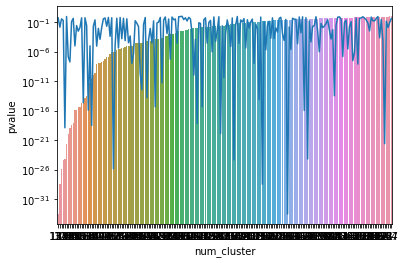

In [116]:

# try t-test

from scipy import stats

DF_vec_trans_SF = DF_vec_trans_train_val[DF_vec_trans_train_val['predicted_SF']==1]
DF_vec_trans_SF=DF_vec_trans_SF.drop(columns=['predicted_SF'])
DF_vec_trans_SF.index=range(len(DF_vec_trans_SF))


DF_vec_trans_nonSF = DF_vec_trans_test[DF_vec_trans_test['predicted_SF']==0]
DF_vec_trans_nonSF=DF_vec_trans_nonSFT.drop(columns=['predicted_SF'])
DF_vec_trans_nonSF.index=range(len(DF_vec_trans_nonSFT))

statistic, pvalue = stats.ttest_ind(DF_vec_trans_SFT,DF_vec_trans_nonSFT,axis=0)
plt.figure()
plt.yscale('log',basey=10)
plt.plot(range(len(pvalue)),pvalue)
plt.xlabel('Clusters')
plt.ylabel('p-value sorted')
pvalue_0_05=pvalue<0.05
DF_pvalue=pd.DataFrame(pvalue,columns=['pvalue'])
DF_pvalue['num_cluster']=range(len(DF_pvalue))
DF_pvalue=DF_pvalue.sort_values(by=['pvalue'])
plot_order = DF_pvalue.sort_values(by='pvalue', ascending=True).num_cluster.values

plt.yscale('log',basey=10)
sns.barplot(x='num_cluster',y='pvalue',data=DF_pvalue,order=plot_order)

pvalue_0_05=pvalue<0.05
DF_pvalue_05=pd.DataFrame(pvalue_0_05,columns=['pvalue'])
DF_pvalue_05['num_cluster']=range(len(DF_pvalue_05))
DF_true=DF_pvalue_05[DF_pvalue_05['pvalue']==True]


In [118]:
len(DF_true)

105